# ModelCheckpoint Callback

In [1]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

from shared_utilities import CustomDataModule, LightningModel

In [2]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.ReLU(),
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [3]:
torch.manual_seed(123)

dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)

In [4]:
from lightning.pytorch.callbacks import ModelCheckpoint

callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True)
]

In [5]:
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.05)

trainer = L.Trainer(
    callbacks=callbacks,  # New!!!
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

trainer.fit(model=lightning_model, datamodule=dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebastian/miniforge3/envs/lightning2/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: logs/my-model

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/sebastian/miniforge3/envs/lightning2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sebastian/miniforge3/envs/lightning2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


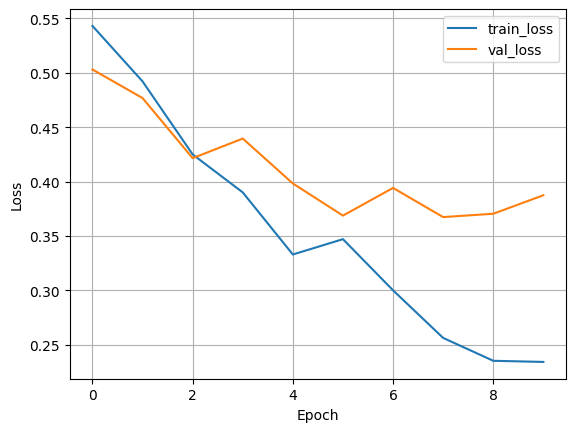

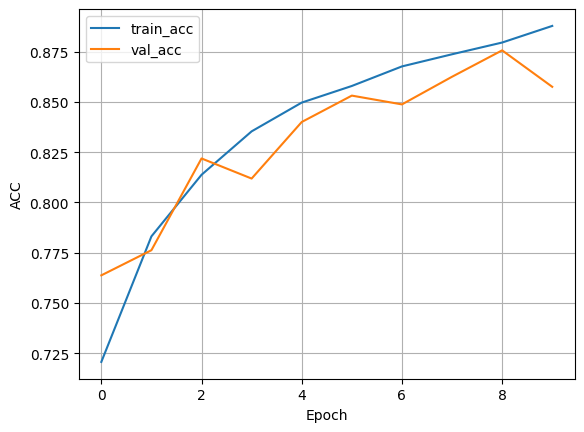

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

# Use the Best Checkpoint

In [7]:
trainer.test(model=lightning_model, datamodule=dm)

/Users/sebastian/miniforge3/envs/lightning2/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8557500243186951     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8557500243186951}]

In [8]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")

Restoring states from the checkpoint path at logs/my-model/version_0/checkpoints/epoch=8-step=4050.ckpt
Loaded model weights from checkpoint at logs/my-model/version_0/checkpoints/epoch=8-step=4050.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8622499704360962     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8622499704360962}]

In [9]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")

Restoring states from the checkpoint path at /Users/sebastian/Developer/github_rasbt/machine-learning-notes/templates/modern-early-stop-with-checkpointing/logs/my-model/version_0/checkpoints/last.ckpt
Loaded model weights from checkpoint at /Users/sebastian/Developer/github_rasbt/machine-learning-notes/templates/modern-early-stop-with-checkpointing/logs/my-model/version_0/checkpoints/last.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8557500243186951     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8557500243186951}]

In [10]:
path = trainer.checkpoint_callback.best_model_path

lightning_model = LightningModel.load_from_checkpoint(
    path, learning_rate=0.1, model=pytorch_model
)
lightning_model.eval();